In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}





Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
cd drive/project_data/Yolo_type_data/

/content/drive/project_data/Yolo_type_data


In [0]:
ls

datalab/  drive/


In [0]:
import keras
import tensorflow as tf
from keras.models import Model
from keras import layers
from keras.models import Sequential
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import numpy as np
import os
import cv2
import math

Using TensorFlow backend.


In [0]:
X = np.load('X.npy')
Y = np.load('Yshape.npy')

print(X.shape)
print(Y.shape)

(21503, 300, 300, 3)
(21503, 9, 9, 5, 25)


In [0]:
B = np.ones((21503,9,9,5,4), dtype='float32')
for b in range(21503):
  for i in range(9):
    for j in range(9):
      for k in range(5):
        
        B[b,i,j,0,0] = i * 33.33 + 15
        B[b,i,j,0,1] = j * 33.33 + 15
        B[b,i,j,0,2] = 15
        B[b,i,j,0,3] = 15
        
        B[b,i,j,1,0] = i * 33.33 + 15
        B[b,i,j,1,1] = j * 33.33 + 15
        B[b,i,j,1,2] = 35 
        B[b,i,j,1,3] = 35
        
        B[b,i,j,2,0] = i * 33.33 + 15
        B[b,i,j,2,1] = j * 33.33 + 15
        B[b,i,j,2,2] = 50
        B[b,i,j,2,3] = 80
        
        B[b,i,j,3,0] = i * 33.33 + 15
        B[b,i,j,3,1] = j * 33.33 + 15
        B[b,i,j,3,2] = 100
        B[b,i,j,3,3] = 100
        
        B[b,i,j,4,0] = i * 33.33 + 15
        B[b,i,j,4,1] = j * 33.33 + 15
        B[b,i,j,4,2] = 140
        B[b,i,j,4,3] = 80

B = B / 300 

In [0]:
LABELS = ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
IMAGE_H, IMAGE_W = 300, 300
GRID_H,  GRID_W  = 9 , 9
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [0]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
#true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
true_boxes  = Input(shape=(9, 9, 5 , 4))

#############################################################
####### VGG16 Model  ########################################
#############################################################
# Block 1
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(input_image)
x = BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3')(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3')(x)
x = BatchNormalization()(x)
#x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

#############################################################
######## Skip connection  ###################################
#############################################################

skip_connection = x

x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
#############################################################
######## Extra Layers  ######################################
#############################################################

# Block 6
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block6_conv1')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block6_conv2')(x)
x = BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block6_conv3')(x)
x = BatchNormalization()(x)

# Block 7
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization()(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)


# Merge
x = concatenate([skip_connection, x])



# Block 8
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x) 
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)


# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])



model = Model([input_image, true_boxes], output)




In [0]:
def closs(Y_true, Y_pred):
    
    """
    Y_true.shape = (batch_size, 49, 6)
    6 => x, y, h, w, confidence, class

    Y_pred.shape = (batch_size, 9, 9, 5, 25)
    9 x 9 cells
    5 frames per cell 
    25 preds per frame (x, y, h, w, confidence, [20 class preddiction] )
    """
    
    """
    Here xi = 9, yi = 9, frames = 5, preds = 25 
    """
    
    ############################################################################
    ###### The code below can be implemented in the loss function itself########
    ######### However, as of now we have Y_data in such shape###################
    ############################################################################
    
    
    """
    batch_size, xi, yi, frames, preds = Y_pred.shape

    # mask Y_true
    #Y = np.zeros((batch_size, xi, yi, frames, preds))
    Y = np.zeros((16, 9, 9, 5, 25))

    
    #for i in range(batch_size):
    for i in range(16):
        for j in range(49):
            # if confidence is greater than 0
            
            #if(Y_true[_,_,_] > 0):  
                
              #cell_x = tf.cast(tf.floor(tf.divide(tf.multiply(Y_true[i,j,0], 300), 9)), dtype=tf.int32)
              #cell_y = tf.cast(tf.floor(tf.divide(tf.multiply(Y_true[i,j,1], 300), 9)), dtype=tf.int32)
              
              alpha, beta = Y_true[i,j,0], Y_true[i,j,0]
              
              cell_x = int((alpha * 300) // 33.3333)
              cell_y = int((beta * 300) // 33.3333)


              # mask confidence
              Y[i,cell_x,cell_y,0:5,4] = Y_true[i,j,4]

              # mask center
              Y[i,cell_x,cell_y,0:5,0] = Y_true[i,j,0]
              Y[i,cell_x,cell_y,0:5,1] = Y_true[i,j,1]

              # mask class
              cl_index = int(Y_true[i,j,5] + 5) 
              Y[i,cell_x,cell_y,0:5,cl_index] = 1

              # mask h and w (sqrt of height and width)
              Y[i,cell_x,cell_y,0:5,2] = Y_true[i,j,2] ** (0.5)
              Y[i,cell_x,cell_y,0:5,3] = Y_true[i,j,3] ** (0.5)
    """
    
    # epsilon is small value to avoid division from zero
    epsilon = 0.1
    
    # Now we have Y and Y_pred
    # Reshapr Y & Y_pred
    
    Y = Y_true # Remove this line when above code is implemented
    
    Y = tf.reshape(Y,[-1,81,5,25])
    Y_pred = tf.reshape(Y_pred,[-1,81,5,25])
    
    # loss x, y, h & w
    # (abs (divide with pred confidence ( multiply with true confidence ( square ( difference ) ) ) ) )
    lossx = tf.abs(tf.multiply((tf.multiply(tf.square(tf.subtract(Y[:,:,:,0],Y_pred[:,:,:,0])), Y[:,:,:,4]) ), 2))
    lossy = tf.abs(tf.multiply((tf.multiply(tf.square(tf.subtract(Y[:,:,:,1],Y_pred[:,:,:,1])), Y[:,:,:,4]) ), 2))
    lossh = tf.abs(tf.multiply((tf.multiply(tf.square(tf.subtract(Y[:,:,:,2],Y_pred[:,:,:,2])), Y[:,:,:,4]) ), 5))
    lossw = tf.abs(tf.multiply((tf.multiply(tf.square(tf.subtract(Y[:,:,:,3],Y_pred[:,:,:,3])), Y[:,:,:,4]) ), 5))
    
    # loss conf for object 
    loss_obj = tf.abs(tf.multiply(tf.multiply(tf.square(tf.subtract(Y[:,:,:,4], Y_pred[:,:,:,4])), Y[:,:,:,4]), 3))
    # loss conf for no obj
    loss_noobj = tf.square(tf.subtract(Y[:,:,:,4], Y_pred[:,:,:,4])) * 0.5
    # loss class
    """
    loss_cl = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y[:,:,:,5:25], logits=Y[:,:,:,5:25])
    loss_cl = tf.reduce_sum(loss_cl * 1) 
    """
    loss_cl = tf.multiply(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y_pred[:,:,:,5:25], labels=Y[:,:,:,5:25])), 8)
    
    
    
    loss1 = lossx + lossy + lossh + lossw
    loss2 = loss_noobj + loss_obj
    loss3 = loss_cl
    
    loss = loss1 + loss2 + loss3
    
    loss = tf.Print(loss, [loss1], message='Loss Points \t', summarize=1000)
    loss = tf.Print(loss, [loss2], message='confidence \t', summarize=1000)
    loss = tf.Print(loss, [loss3], message='Loss class \t', summarize=1000)
    
    return loss

In [0]:
#model = keras.models.load_model('a.h5')
model.load_weights('a.h5')

In [0]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=closs, optimizer=optimizer)



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
model.fit([X, B], Y, batch_size=8, epochs=5)

Epoch 1/5
   40/21503 [..............................] - ETA: 37:05:26 - loss: 46.8217

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [0]:
im = X[88]

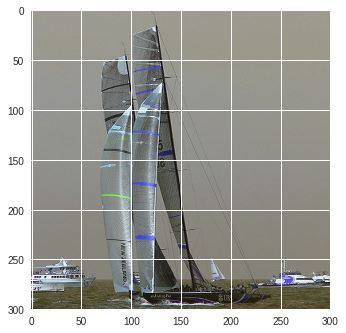

In [0]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)


In [0]:
pred = model.predict([X[88:89],B[0:1]])

In [0]:
pred.shape

(1, 9, 9, 5, 25)

In [0]:
alia = np.reshape(pred, (1,81,5,25))

In [0]:
katrina = np.reshape(pred, (405,25))

In [0]:
katrina.shape

(405, 25)

In [0]:
katrina[0]

array([ 1.1122626e+03,  3.5238223e+02, -4.9731573e+02, -1.8955552e+03,
       -7.2570486e+00,  6.0275910e+06,  6.0166690e+06,  6.0185055e+06,
        6.0180995e+06,  6.0192420e+06,  6.0154995e+06,  6.0234175e+06,
        6.0172565e+06,  6.0214780e+06,  6.0181665e+06,  6.0168320e+06,
        6.0171555e+06,  6.0176145e+06,  6.0165475e+06,  6.0274355e+06,
        6.0190400e+06,  6.0178850e+06,  6.0171885e+06,  6.0168620e+06,
        6.0167910e+06], dtype=float32)